In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
import mc_plot_utils
from mc_plot_utils import *

In [3]:
env = gym.make('Blackjack-v1')

print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Episode 50000/50000.The length of q table: 280


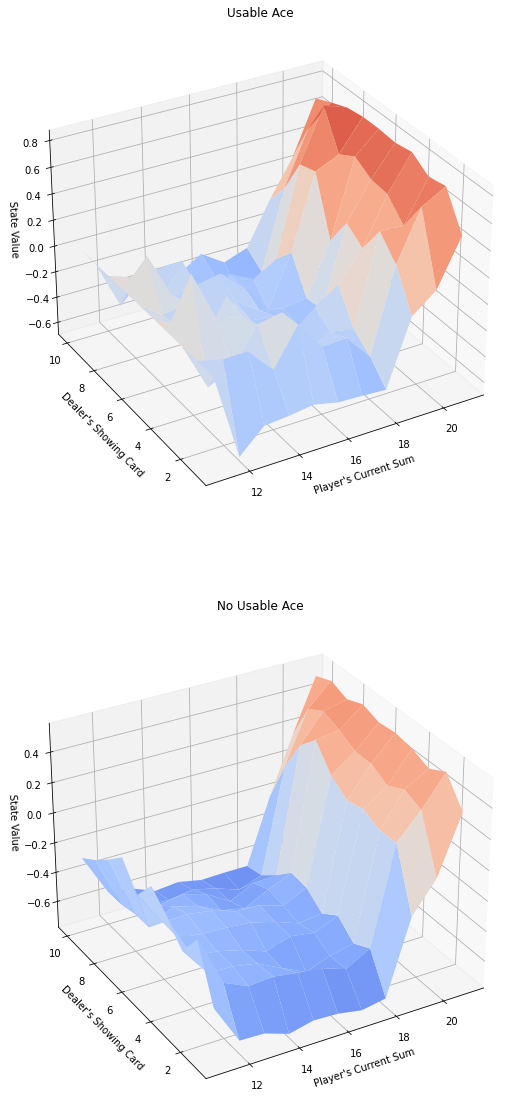

Episode 500000/500000.

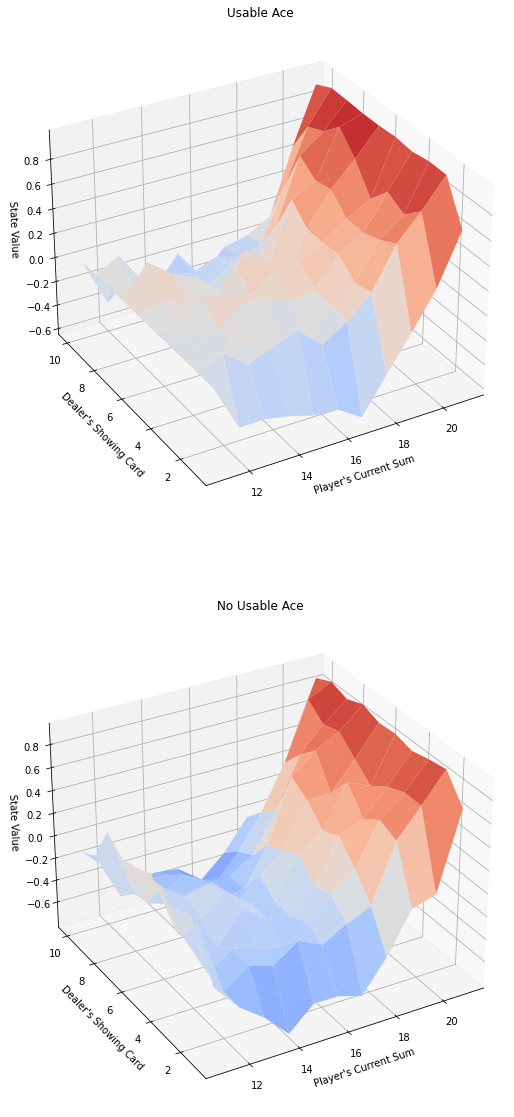

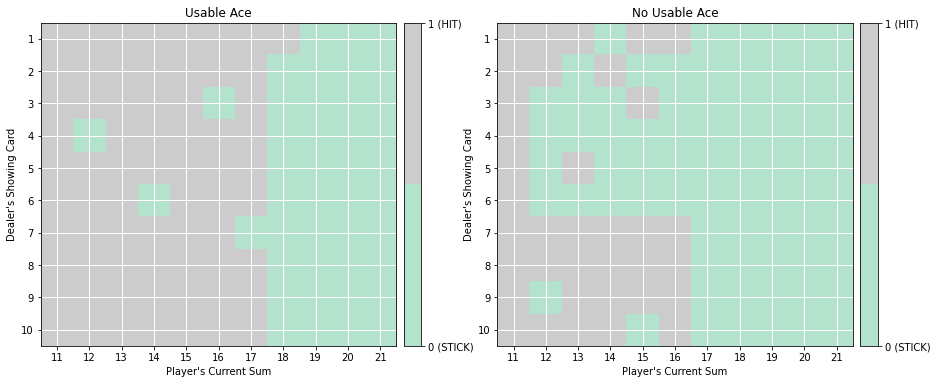

In [4]:
"""Monte-Carlo Prediction Part"""
def generate_episode_from_limit_stochastic(bj_env):
    """In particular, player selects action STICK with 80% probability if the sum is greater than 18;
        and, if the sum is 18 or below, player selects action HIT with 80% probability."""
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break

    return episode


def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # state is key, value is value function
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma ** i for i in range(len(rewards) + 1)])

        # every-visit state-action value function
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:] * discounts[:-(1 + i)])
            N[state][actions[i]] += 1
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    return Q


Q_table = mc_prediction_q(env, 50000, generate_episode_from_limit_stochastic)
print("The length of q table:", len(Q_table))

# obtain the corresponding state-value function，Q's key is state, value is q(s, a)
V_to_plot = dict((k, (k[0]>18)*(np.dot([0.8, 0.2], v)) + (k[0]<=18)*(np.dot([0.2, 0.8], v))) \
         for k, v in Q_table.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [ ]:
"""Constant-alpha Monte-Carlo Control Part"""


def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    a_star = np.argmax(Q_s)
    policy_s[a_star] = 1 - epsilon + (epsilon / nA)
    return policy_s

def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def update_Q(env, episode, Q, alpha, gamma=1.0):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        G_t = sum(rewards[i:]*discounts[:-(1+i)])
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(G_t - old_Q)
    return Q


def mc_control(env, num_episodes, alpha, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        #eps = max(eps_start*eps_decay, eps_min)
        eps = 0.2
        episode = generate_episode_from_Q(env, Q, epsilon=eps, nA=nA)
        Q = update_Q(env, episode, Q, alpha)

    policy = dict((state_key, np.argmax(v)) for state_key, v in Q.items())

    return policy, Q

Episode 5000000/5000000.

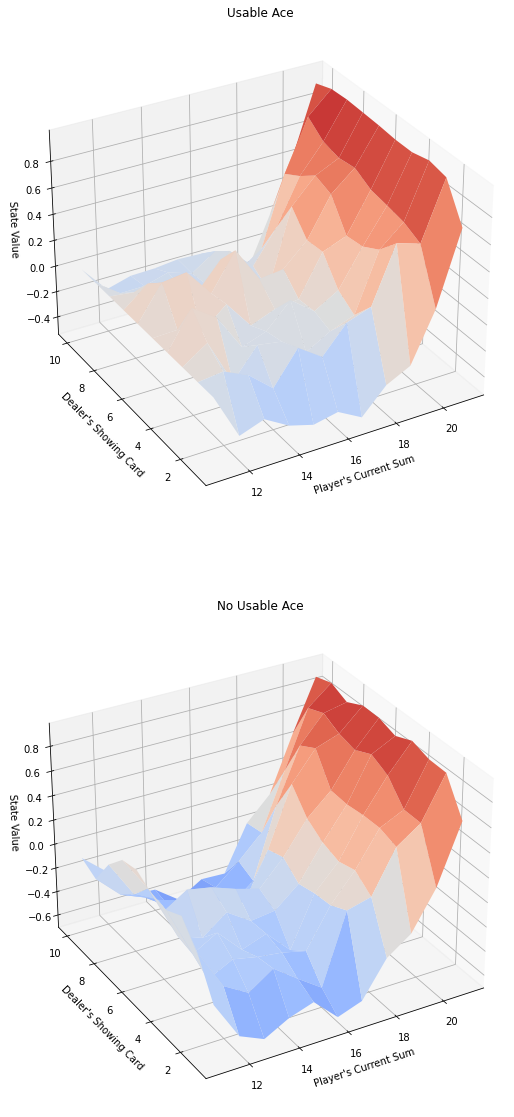

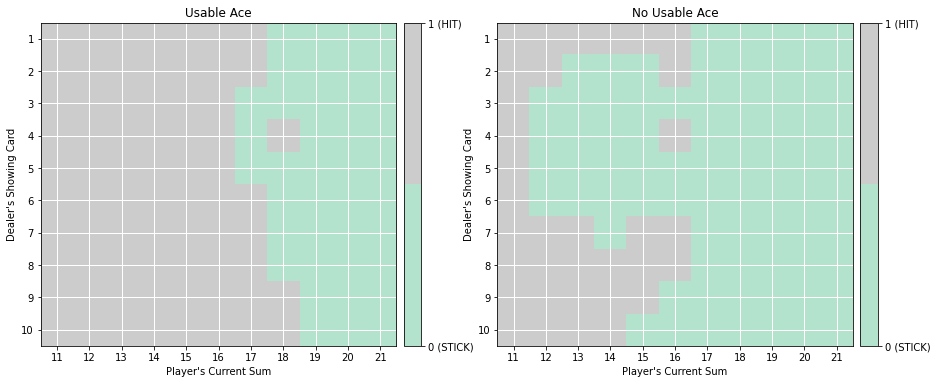

In [5]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 5000000, 0.02)
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

plot_policy(policy)

In [ ]:
#测试策略
